<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1">Prepare data</a></span></li><li><span><a href="#Binary-classification" data-toc-modified-id="Binary-classification-2">Binary classification</a></span><ul class="toc-item"><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2.1">Train model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-2.2">Evaluate</a></span><ul class="toc-item"><li><span><a href="#Cross-validation-score" data-toc-modified-id="Cross-validation-score-2.2.1">Cross validation score</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2.2.2">Confusion matrix</a></span></li><li><span><a href="#Precision/Recall-trade-off" data-toc-modified-id="Precision/Recall-trade-off-2.2.3">Precision/Recall trade-off</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-2.2.4">ROC curve</a></span></li></ul></li></ul></li><li><span><a href="#Multiclass-classification" data-toc-modified-id="Multiclass-classification-3">Multiclass classification</a></span></li></ul></div>

## Prepare data

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

print(f'Object class: {mnist.__class__}')

mnist.keys()

Object class: <class 'sklearn.utils.Bunch'>


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

X.shape, y.shape

((70000, 784), (70000,))

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

Label: 5


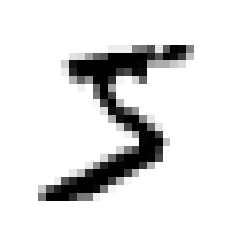

In [4]:
some_digit = X[0]
print('Label:', y[0])

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary');
plt.axis('off');

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
train_size = 60000

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Binary classification

### Train model

In [8]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

### Evaluate

#### Cross validation score

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Predict using dummy classifier that always returns 0

In [12]:
from sklearn.dummy import DummyClassifier

never_5_clf = DummyClassifier(strategy='constant', constant=0)

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [13]:
print(f'Number of poisitive cases is {y_train_5.sum()} out of {len(y_train_5)}')

Number of poisitive cases is 5421 out of 60000


The dataset is highly unbalanced

#### Confusion matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_pred.shape[0]

60000

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
# perfect classifier
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [17]:
from sklearn import metrics

metrics.precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
metrics.recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
metrics.f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall trade-off

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
# rising the threshold decreases recall

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [24]:
precisions, recalls, thresholds = metrics.precision_recall_curve(
    y_train_5, y_scores)

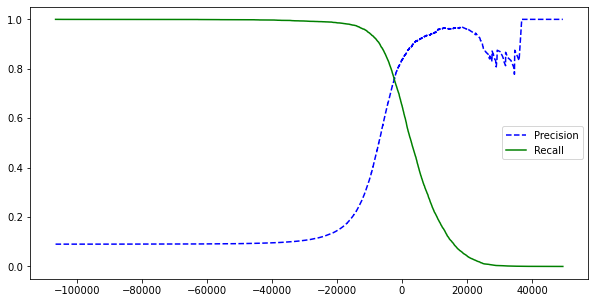

In [25]:
plt.figure(figsize=(10, 5))

plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall');
plt.legend();

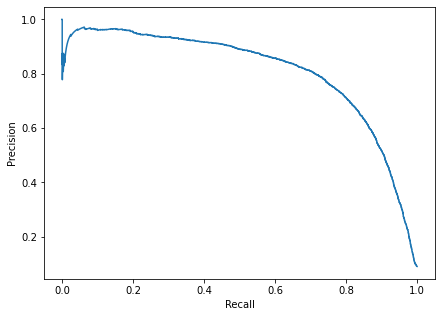

In [29]:
plt.figure(figsize=(7, 5))

plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision');

#### ROC curve

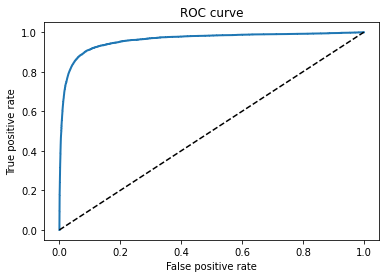

In [34]:
# fpr - false positive rate
# tpr - true position rate
fpr, tpr, thresholds = metrics.roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

In [35]:
metrics.roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [39]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = metrics.roc_curve(
    y_train_5, y_scores_forest)

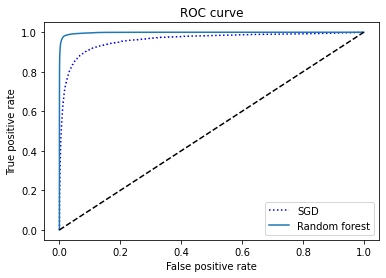

In [42]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random forest')
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

In [43]:
metrics.roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass classification

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [46]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = metrics.confusion_matrix(y_train, y_train_pred)
conf_mx

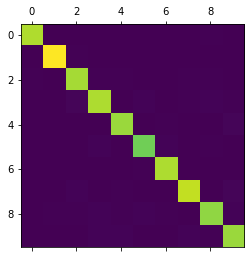

In [51]:
plt.matshow(conf_mx);

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

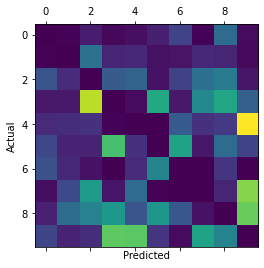

In [65]:
plt.matshow(norm_conf_mx);
plt.xlabel('Predicted')
plt.ylabel('Actual');